In [23]:
# from scripts.setup_libs import *
# from scripts.plot_clas import *
from numpy.testing import assert_array_equal, assert_array_almost_equal, assert_equal, assert_almost_equal
from pandas.testing import assert_frame_equal

In [1]:
import numpy as np
import pandas as pd

from IPython.display import Image 
from matplotlib import pyplot as plt
plt.style.use('ggplot')
plt.rcParams['figure.figsize'] = 7, 5
from matplotlib.colors import ListedColormap
import seaborn as sns
sns.set_style('white')


from sklearn.tree import DecisionTreeRegressor as DTR, DecisionTreeClassifier as DTC
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
from sklearn.ensemble import BaggingClassifier, BaggingRegressor
from sklearn.ensemble import AdaBoostClassifier, AdaBoostRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.ensemble import GradientBoostingClassifier



from sklearn.datasets import make_regression, make_classification, make_circles
from sklearn.metrics import mean_squared_error as MSE, accuracy_score
from sklearn.model_selection import cross_val_score, StratifiedKFold, GridSearchCV, train_test_split

In [2]:
import matplotlib.pyplot as plt
import numpy as np
import matplotlib.patches as mpatches
from matplotlib.colors import ListedColormap

def get_grid(data, border=1., step=.01): #получаем все точки плоскости
    x_min, x_max = data[:, 0].min() - border, data[:, 0].max() + border
    y_min, y_max = data[:, 1].min() - border, data[:, 1].max() + border
    return np.meshgrid(np.arange(x_min, x_max, step),
                       np.arange(y_min, y_max, step))

def plot_model(X_train, y_train, clf, title=None, proba=False):
    xx, yy = get_grid(X_train) #получаем все точки плоскости
    
    # предсказываем значения для каждой точки плоскости
    
    if proba: # нужно ли предсказывать вероятности 
        predicted = clf.predict_proba(np.c_[xx.ravel(), yy.ravel()])[:, 1].reshape(xx.shape)
    else:
        predicted = clf.predict(np.c_[xx.ravel(), yy.ravel()]).reshape(xx.shape)
    
    # Отрисовка плоскости
    ax = plt.gca()
    ax.pcolormesh(xx, yy, predicted, cmap='spring')
    
    # Отрисовка точек
    
    ax.scatter(X_train[:, 0], X_train[:, 1], c=y_train, s=100, cmap='spring', edgecolors='b')
    colors = ['purple', 'yellow', 'orange']
    patches = []
    for yi in np.unique(y_train):
        patches.append(mpatches.Patch(color=colors[int(yi)], label='$y_{pred}=$'+str(int(yi))))
    ax.legend(handles=patches)
    plt.title(title)
    return clf

def plot_decision_boundary(classifier, X, y, N = 10, scatter_weights = None , ax = None ):
    if scatter_weights is None:
        scatter_weights = np.ones(len(y))
    '''Utility function to plot decision boundary and scatter plot of data'''
    x_min, x_max = X[:, 0].min() - .1, X[:, 0].max() + .1
    y_min, y_max = X[:, 1].min() - .1, X[:, 1].max() + .1
    xx, yy = np.meshgrid( np.linspace(x_min, x_max, N), np.linspace(y_min, y_max, N))

    
    #Check what methods are available
    if hasattr(classifier, "decision_function"):
        zz = np.array( [classifier.decision_function(np.array([xi,yi]).reshape(1,-1)) for  xi, yi in zip(np.ravel(xx), np.ravel(yy)) ] )
    elif hasattr(classifier, "predict_proba"):
        zz = np.array( [classifier.predict_proba(np.array([xi,yi]).reshape(1,-1))[:,1] for  xi, yi in zip(np.ravel(xx), np.ravel(yy)) ] )
    else :
        zz = np.array( [classifier(np.array([xi,yi]).reshape(1,-1)) for  xi, yi in zip(np.ravel(xx), np.ravel(yy)) ] )
            
    # reshape result and plot
    Z = zz.reshape(xx.shape)
    cm_bright = ListedColormap(['#FF0000', '#0000FF'])
    
    #Get current axis and plot
    if ax is None:
        ax = plt.gca()
    ax.contourf(xx, yy, Z, 2, cmap='RdBu', alpha=.5)
    ax.contour(xx, yy, Z,  2, cmap='RdBu')
    ax.scatter(X[:,0],X[:,1], c = y, cmap = cm_bright, s = scatter_weights * 40)
    ax.set_xlabel('$X_1$')
    ax.set_ylabel('$X_2$')

    
def plot_AdaBoost_scratch_boundary(estimators,estimator_weights, X, y, N=10, ax = None ):
    def AdaBoost_scratch_classify(x_temp, est,est_weights ):
        '''Return classification prediction for a given point X and a previously fitted AdaBoost'''
        temp_pred = np.asarray( [ (e.predict(x_temp)).T* w for e, w in zip(est,est_weights )]  ) / est_weights.sum()
        return np.sign(temp_pred.sum(axis = 0))
    
    
    '''Utility function to plot decision boundary and scatter plot of data'''
    x_min, x_max = X[:, 0].min() - .1, X[:, 0].max() + .1
    y_min, y_max = X[:, 1].min() - .1, X[:, 1].max() + .1
    xx, yy = np.meshgrid( np.linspace(x_min, x_max, N), np.linspace(y_min, y_max, N))


    zz = np.array( [AdaBoost_scratch_classify(np.array([xi,yi]).reshape(1,-1), estimators,estimator_weights ) for  xi, yi in zip(np.ravel(xx), np.ravel(yy)) ] )
            
    # reshape result and plot
    Z = zz.reshape(xx.shape)
    cm_bright = ListedColormap(['#FF0000', '#0000FF'])
    
    if ax is None:
        ax = plt.gca()
    ax.contourf(xx, yy, Z, 2, cmap='RdBu', alpha=.5)
    ax.contour(xx, yy, Z,  2, cmap='RdBu')
    ax.scatter(X[:,0],X[:,1], c = y, cmap = cm_bright)
    ax.set_xlabel('$X_1$')
    ax.set_ylabel('$X_2$')
    

# SLIDE (2) Производные для регрессии

Окей, в лекции было очень много страшных формул, теперь можно осознать зачем это нужно.

Пусть мы хотим бустить регрессию со стандартной функцией потерь $MSE$:

$$\mathcal{L}(a, x,y) = (a(x_i) - y_i)^2$$

Необходимо найти через взятие производных:

1. Константный вектор $[f_0]_{i=1}^{N}$
$$f_0(x) = \arg\min_{ c\in \mathbb{R}} \sum_{i=1}^n \mathcal{L}(c, y_i)$$ 

2. Градиенты функции потерь
$$g_{i}^{t} = -\Big[\frac{\partial \mathcal{L}(f_t, x_i, y_i)}{\partial f_t(x_i)}\Big]_{i=1}^N$$

3. Коэффициенты при композиции 
$$\alpha_{t + 1} = \arg\min_\alpha \sum_{i=1}^N \mathcal{L}(f_{t}(x_i) + \alpha b_{t+1}(x_i), y_i)$$

### Sample 1
#### Input:
```python
y = np.array([1, 2, 3])
f = np.array([2, 2, 2])
b = np.array([0, 2, 4])
```
#### Output:
```python
f_0 = 2.0
g = [-2  0  2] 
alpha = -0.2

```

# TASK

In [24]:
def init(y_i: np.array) -> float:
    n = len(y_i)
    f_0 = y_i.sum() / n
    return f_0

def grad(a: np.array, y: np.array) -> np.array:
    g = -2*(a - y)
    return g

def alpha(f :np.array, b: np.array, y: np.array) -> float:
    alpha = (b*(f-y)).sum() / (b**2).sum()
    return alpha

# TESTS

In [25]:
y = np.array([1, 2, 3])
f = np.array([2, 2, 2])
b = np.array([0, 2, 4])

f_0 = init(y)
g = grad(f,y)
al = alpha(f,b,y)


assert np.abs(f_0 - 2.0)   < 1e-9
assert_array_almost_equal(g, np.array([-2, 0, 2]))
assert np.abs(al - (-0.2)) < 1e-9
######################################################
y = np.arange(20)
f = np.ones(20) * 10
b = np.arange(20) - 1

f_0 = init(y)
g = grad(f,y)
al = alpha(f,b,y)


assert np.abs(f_0 - 9.5)   < 1e-2
assert_array_almost_equal(g, np.arange(-20,20, 2))
assert np.abs(al - (-0.2748)) < 1e-2
print('Well Done!')

-0.2
-0.27488151658767773
Well Done!


# SLIDE (2) GradientBoosting

Реализуйте градиентный бустинг на решающих деревьях для регрессии с логгированием.Верните модель, которая будет хранить в себе `n_estimatos` обученных деревьев и коэффициенты, чтобы с их помощью потом найти результат предсказания.

Также необходимо реализовать логгирование в течение обучения.
* `self.estimators` - лист c деревьями
* `self.alpha` - лист с коэффициентами альфа
* `self.f_list` - лист со значениями комбинаций алгоритма $f_T(x_i) = f_0(x_i) + \sum_{t=1}^{T}\alpha_tb_t(x_i)$
* `self.g_list` - лист с векторами градиентов на каждой итерации $g_{i}^{t} = -\Big[\frac{\partial \mathcal{L}(f_t, x_i, y_i)}{\partial f_t(x_i)}\Big]_{i=1}^N$
* `self.b_list` - лист со значениями базового обучаемого дерева на тренировачной выборке на каждой итерации 

Примечания:
* Обрывать алгоритм не нужно, необходимо обучить все деревья.
* Начальный константный вектор из $f_0$ логгировать не нужно, однако не забудьте его добавить в `predict` c нужным количеством объектов!

### Sample 1
#### Input:
```python
n_estimators = 2
max_depth=3
X_train = np.array([[0], [1], [2], [3], [4]])
y_train = np.array([0, 2, 4, 2, 0])
X_test  = np.array([[1.2], [2.3]])
y_test  = np.array([2.2, 3.7])
```
#### Output:
```python
y_test_pred = [2, 4]

model.f_list = [array([0.0, 2.0, 3.0, 3.0, 0.0]), 
                array([0.0, 2.0, 4.0, 2.0, 0.0])]

model.g_list = [array([-3.2,  0.8, 4.8, 0.8, -3.2]), 
                array([ 0.0,  0.0, 2.0,-2.0,  0.0])]

model.b_list = [array([-3.2, 0.8, 2.8,  2.8, -3.2]), 
                array([ 0.0, 0.0, 2.0, -2.0,  0.0])]
```

# TASK

In [11]:
import numpy as np
from sklearn.tree import DecisionTreeRegressor as DTR, DecisionTreeClassifier as DTC
from sklearn.metrics import mean_squared_error

class MyGradBoost():
    def __init__(self, n_estimators=10, max_depth=3):
        self.n_estimators = n_estimators
        self.max_depth = max_depth
        self.estimators_ = np.array([DTR(max_depth=self.max_depth) for _ in range(n_estimators)])
        self.alpha = []
        self.f_list = []
        self.b_list = []
        self.g_list = []
        self.f_0_ = None
        
    def init(self, y_i: np.array) -> np.array:
        n = len(y_i)
        f_0 = y_i.sum() / n
        return f_0

    def grad(self, a: np.array, y: np.array) -> np.array:
        g = -2*(a - y)
        return g

    def alpha_f(self, f :np.array, b: np.array, y: np.array) -> float:
        alph = (b*(f-y)).sum() / (b**2).sum()
        return alph
        
    def fit(self, X_train: np.array, y_train: np.array):
        self.f_0_ = self.init(y_train)
        f_0 = np.array([self.f_0_ for _ in range(len(y_train))])
        for i in range(self.n_estimators):
            est = self.estimators_[i]
            if i == 0:
                f = f_0
            else:
                f = self.f_list[i-1]
                
            g = self.grad(f, y_train)
            self.g_list.append(g)
            
            est.fit(X_train, g)
            
            b_predict = est.predict(X_train)
            self.b_list.append(b_predict)
            
            alph = self.alpha_f(f, b_predict, y_train)
            self.alpha.append(alph)
            
            new_f = f - alph * b_predict
            self.f_list.append(new_f)
            
        return self
        
    def predict(self, X_test) -> np.array:
        alpha_sum = sum(self.alpha)
        self.alpha /= alpha_sum
        y_pred = np.array([self.f_0_ for _ in range(len(X_test))])
        for i in range(self.n_estimators):
            current_est = self.estimators_[i]
            y_pred += self.alpha[i] * current_est.predict(X_test)
        return y_pred
    
    def score(self, X_test, y_test)-> np.array:
        predict = self.predict(X_test)
        model_score = mean_squared_error(predict, y_test)
        print('model score ', model_score)
        return model_score

# TESTS

In [12]:
n_estimators = 2
max_depth=3
X_train = np.array([[0], [1], [2], [3], [4]])
y_train = np.array([0, 2, 4, 2, 0])
X_test  = np.array([[1.2], [2.3]])
y_test  = np.array([2.2, 3.7])

model = MyGradBoost(n_estimators=n_estimators, max_depth=max_depth).fit(X_train, y_train)
assert model.score(X_test, y_test) < 0.2
######################################################
n_train, n_test, noise = 150, 1000, 0.1
# Generate data
def f(x):
    x = x.ravel()
    return np.exp(-x ** 2) + 1.5 * np.exp(-(x - 2) ** 2)

def generate(n_samples, noise):
    X = np.random.rand(n_samples) * 10 - 5
    X = np.sort(X).ravel()
    y = np.exp(-X ** 2) + 1.5 * np.exp(-(X - 2) ** 2)\
        + np.random.normal(0.0, noise, n_samples)
    X = X.reshape((n_samples, 1))

    return X, y

X_train, y_train = generate(n_samples=n_train, noise=noise)
X_test, y_test = generate(n_samples=n_test, noise=noise)


model = MyGradBoost().fit(X_train, y_train)

assert model.score(X_test, y_test) < 0.02


model = MyGradBoost(n_estimators=100, 
                    max_depth=1).fit(X_train, y_train)

assert model.score(X_test, y_test) < 0.017
print('Well Done')

model score  0.06500000000000003
model score  0.18553243959029522


AssertionError: 

# Useful Graphs

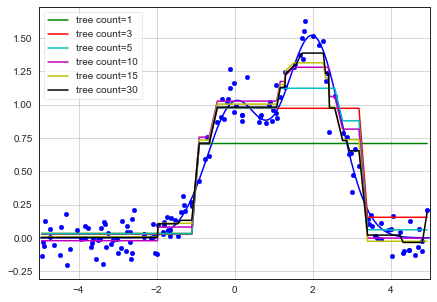

In [142]:
def predict_and_plot(model, X_test, y_test, title):
    y_predict = model.predict(X_test)

    plt.plot(X_test, f(X_test), "b")
    plt.scatter(X_train, y_train, c="b", s=20)
    plt.plot(X_test, y_predict, "g", lw=2)
    plt.xlim([-5, 5])
    plt.title("{} Loss: {:2f}".format(title, model.score(X_test, y_test)))
    plt.grid()


n_train, n_test, noise = 150, 1000, 0.1
# Generate data
def f(x):
    x = x.ravel()
    return np.exp(-x ** 2) + 1.5 * np.exp(-(x - 2) ** 2)

def generate(n_samples, noise):
    X = np.random.rand(n_samples) * 10 - 5
    X = np.sort(X).ravel()
    y = np.exp(-X ** 2) + 1.5 * np.exp(-(X - 2) ** 2)\
        + np.random.normal(0.0, noise, n_samples)
    X = X.reshape((n_samples, 1))

    return X, y

X_train, y_train = generate(n_samples=n_train, noise=noise)
X_test, y_test = generate(n_samples=n_test, noise=noise)

model = MyGradBoost(n_estimators=30, 
                    max_depth=1).fit(X_train, y_train)

ind =  [1,3,5,10,15,30]

# GradientBoostingRegressor
plt.plot(X_test, f(X_test), "b")
plt.scatter(X_train, y_train, c="b", s=20)
n_est = [1,3,5,10,15,30]
f = np.array(model.f_list)
for i, n in enumerate(n_est):
    colors = ['g', 'r', 'c', 'm', 'y', 'k']
    plt.plot(X_train, f[n-1], color=colors[i], label="tree count={}".format(n))

plt.xlim([-5, 5])   
plt.legend()
plt.grid()
plt.show()

# SLIDE (2) AdaBoost step

Реализуйте одну итерацию алгоритма AdaBoost:
1. Обучите дерево $b$ на $X_{train}$ и верните $y_{pred}$
2. Найдите среднюю взвешанную ошибку
$$error = Q(b_t, X, y) = \frac{1}{N}\sum_{i=1}^{N}w_i^{(t-1)}[y_i \neq b_t(x)]$$

3. Найдите коэффициент $\alpha$ (для корректного выполнения добавим $eps$)
$$\alpha = \frac{1}{2}\ln\Big(\frac{1-error + eps}{error + eps}\Big)$$

4. Найдите новые веса:
$$w_i^{new} = w_iexp\Big(-\alpha y_i b(x_i)\Big)$$
$$\tilde{w}_i^{new} = \frac{w_i^{new}}{\sum_{i=1}^{N}w_i^{new}}$$

### Sample 1
#### Input:
```python
X_train = np.array([[0, 0], [4, 0], [0, 4], [4, 4]])
y_train = np.array([-1, -1, -1, 1])
```
#### Output:
```python
y_pred =  [-1 -1 -1 -1] 
error = 0.056 
alpha = 1.417 
new_weights = [0.05882403 0.41176819 0.02941201 0.49999576]
```

In [170]:
import math

def boost_step(estimator, weights, X_train, y_train, eps = 1e-6):
    n = len(X_train)
    estimator.fit(X_train, y_train)
    y_pred = estimator.predict(X_train)
    error = 0
    for i in range(n):
        if (y_train[i] != y_pred[i]):
            error += weights[i] 
    error /= sum(weights)
    alpha = math.log((1 - error + eps)/(error+eps)) / 2
    new_weights = []
    for i in range(n):
        new_weight = weights[i]*math.e**(-alpha*y_train[i]*y_pred[i])
        new_weights.append(new_weight)
    new_weights_sum = sum(new_weights)
    for i in range(n):
        new_weights[i] /= new_weights_sum
    return y_pred, error, alpha, new_weights

# TESTS

In [171]:
######################################################
X_train = np.array([[0, 0], [4, 0], [0, 4], [4, 4]])
y_train = np.array([-1, -1, -1, 1])

estimator = DTC(max_depth=1, random_state=4)
sample_weights = [0.1, 0.7, 0.05, 0.05]
y_pred, error, alpha, new_weights = boost_step(estimator, sample_weights, X_train, y_train)
assert_array_almost_equal(y_pred, np.array([-1, -1, -1, -1])) 
assert np.abs(error - 0.056) < 1e-2 
assert np.abs(alpha - 1.417) < 1e-2 
assert_array_almost_equal(new_weights, np.array([0.05882403, 0.41176819, 0.02941201, 0.49999576]))
######################################################
X_train = np.array([[0, 0], [3, 3], [5, 5], [10, 10]])
y_train = np.array([-1, -1, 1, 1])
estimator = DTC(max_depth=1, random_state=6)
sample_weights = [0.1, 0.7, 0.05, 0.05]

y_pred, error, alpha, new_weights = boost_step(estimator, sample_weights, X_train, y_train)


assert_array_almost_equal(y_pred, np.array([-1, -1, 1, 1])) 
assert np.abs(error - 0.0) < 1e-2 
assert np.abs(alpha - 6.907) < 1e-2 
assert_array_almost_equal(new_weights, np.array([0.11111111, 0.77777778, 0.05555556, 0.05555556]))

print('Well Done!')

Well Done!


# SLIDE (2) AdaBoost classifier

Реализуйте AdaBoost для бинарной классификации на деревьях высоты 1. Верните модель, которая будет хранить в себе `n_estimatos` обученных деревьев и коэффициенты, чтобы с их помощью потом найти результат предсказания.

Также необходимо реализовать логгирование в течение обучения.
* `self.sample_weights_list` - лист с весами объектов на каждой итерации
* `self.y_pred_list` - лист с предсказанием каждого следующего дерева (не комбинации)
* `self.error_list` - лист с ошибками

Примечания:
* Обрывать алгоритм не нужно, необходимо обучить все деревья.
* Начальные веса логгировать не нужно
* `predict_proba` реализовывать не нужно

### Sample 1
#### Input:
```python
n_estimators = 2
X_train = np.array([[0, 0], [4, 0], [0, 4], [4, 4]])
y_train = np.array([-1, -1, -1, 1])
X_test  = np.array([[1, 0], [5, 5]])
y_test  = np.array([-1, 1])
```
#### Output:
```python
y_test_pred = [0, 1]

model.sample_weight = [array([0.167, 0.167, 0.167, 0.5]), 
                       array([ 0.1,  0.5,  0.1, 0.3])]
model.y_pred = [array([-1, -1, -1, -1]),
                array([-1,  1, -1,  1])]

model.alpha = [0.25, 0.167]
```


# TASK

In [200]:
import numpy as np
from sklearn.tree import DecisionTreeClassifier as DTC

class MyAdaBoost():
    def __init__(self, n_estimators=10):
        self.estimators_ = np.array([DTC(max_depth=1) for _ in range(n_estimators)])
        self.alpha = []
        self.sample_weights_list = []
        self.y_pred_list = []
        self.error_list = []
        self.eps = 1e-6
        
    def fit(self, X_train: np.array, y_train: np.array):
        n = len(X_train)
        weights = np.array([1/n for _ in range(n)])
        
        for i in range(len(self.estimators_)):
            est = self.estimators_[i]
            est.fit(X_train, y_train, weights)
            y_pred = est.predict(X_train)
            self.y_pred_list.append(y_pred)
            
            error = 0
            for j in range(n):
                if (y_train[j] != y_pred[j]):
                    error += weights[j] 
            error /= sum(weights)
            self.error_list.append(error)
            
            alpha = math.log((1 - error + self.eps)/(error+self.eps)) / 2
            self.alpha.append(alpha)
            
            new_weights = []
            for j in range(n):
                new_weight = weights[j]*math.e**(-alpha*y_train[j]*y_pred[j])
                new_weights.append(new_weight)
                
            new_weights_sum = sum(new_weights)
            
            for j in range(n):
                new_weights[j] /= new_weights_sum
                
            self.sample_weights_list.append(new_weights)
            weights = new_weights
            
        return self
        
    def predict(self, X_test) -> np.array:
        pred = None
        for i in range(len(self.estimators_)):
            est = self.estimators_[i]
            alpha = self.alpha[i]
            current = est.predict(X_test) * alpha
            if (pred is None):
                pred = current
            else:
                pred += current
        result = []
        for elem in pred:
            if (elem > 0):
                result.append(1)
            elif (elem < 0):
                result.append(-1)
            else:
                result.append(0)
        return result


# TESTS

In [201]:
######################################################
X_train = np.array([[0, 0], [4, 0], [0, 4], [4, 4]])
y_train = np.array([-1, -1, -1, 1])
X_test  = np.array([[1, 0], [5, 5]])
y_test  = np.array([-1, 1])

model = MyAdaBoost(n_estimators = 2).fit(X_train, y_train)

y_pred_my = model.predict(X_test)

assert_array_almost_equal(y_pred_my, np.array([-1, 1]))

######################################################
X_train = np.array([[0, 0], [4, 4], [5, 5], [10, 10]])
y_train = np.array([-1, -1, 1, 1])
X_test  = np.array([[3, 3], [6, 6]])
y_test  = np.array([-1, 1])

model = MyAdaBoost(n_estimators = 2).fit(X_train, y_train)

y_pred_my = model.predict(X_test)

assert_array_almost_equal(y_pred_my, np.array([-1, 1]))
######################################################
num_samples = 1000
theta = np.linspace(0, 2*np.pi, num_samples)
r1 = 1
r2 = 2

rng = np.random.RandomState(1)

circle = np.hstack([np.cos(theta).reshape((-1, 1)) + (rng.randn(num_samples)[:,np.newaxis] / 8), 
                    np.sin(theta).reshape((-1, 1)) + (rng.randn(num_samples)[:,np.newaxis] / 8)])
lil = r1 * circle
big = r2 * circle
X = np.vstack([lil, big])
y = np.hstack([(-1) * np.ones(num_samples), np.ones(num_samples)])




X_train, X_test, y_train, y_test = train_test_split(X, y,
                                                    test_size=0.3,
                                                    random_state=123,
                                                    shuffle=True)

y_test = y_test.astype('int')


y_pred_my = MyAdaBoost(n_estimators = 20).fit(X_train, y_train).predict(X_test)

assert accuracy_score(y_pred_my, y_test) > 0.95
print('Well Done!')

weights  [[0.16666688888829628, 0.16666688888829628, 0.16666688888829628, 0.49999933333511115], [0.10000039999871999, 0.10000039999871999, 0.4999988000063999, 0.30000039999616007]]
error  [0.25, 0.16666688888829628]
pred  [array([-1, -1, -1, -1]), array([-1, -1,  1,  1])]
alpha  [0.5493048110042772, 0.8047157562324102]
weights  [[0.25, 0.25, 0.25, 0.25], [0.25, 0.25, 0.25, 0.25]]
error  [0.0, 0.0]
pred  [array([-1, -1,  1,  1]), array([-1, -1,  1,  1])]
alpha  [6.907755778981887, 6.907755778981887]
weights  [[0.0005434786399251412, 0.0005434786399251412, 0.0005434786399251412, 0.0005434786399251412, 0.0005434786399251412, 0.0010416659401435058, 0.0005434786399251412, 0.0005434786399251412, 0.0010416659401435058, 0.0010416659401435058, 0.0010416659401435058, 0.0005434786399251412, 0.0005434786399251412, 0.0005434786399251412, 0.0005434786399251412, 0.0005434786399251412, 0.0010416659401435058, 0.0010416659401435058, 0.0005434786399251412, 0.0005434786399251412, 0.0010416659401435058, 0.

# Useful graph

При корректной реализации логирования теперь можно посмотреть на ход обучения в картинках

In [112]:
#Toy Dataset
x1 = np.array([.1,.2,.4,.8, .8, .05,.08,.12,.33,.55,.66,.77,.88,.2,.3,.4,.5,.6,.25,.3,.5,.7,.6])
x2 = np.array([.2,.65,.7,.6, .3,.1,.4,.66,.77,.65,.68,.55,.44,.1,.3,.4,.3,.15,.15,.5,.55,.2,.4])
y = np.array([1,1,1,1,1,1,1,1,1,1,1,1,1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1])
X = np.vstack((x1,x2)).T



In [113]:
boost = MyAdaBoost(n_estimators = 20).fit(X, y)
sample_weight_list = np.array(boost.sample_weight_list)
estimator_list = np.array(boost.estimators_)
alpha = np.array(boost.alpha)

Well Done!


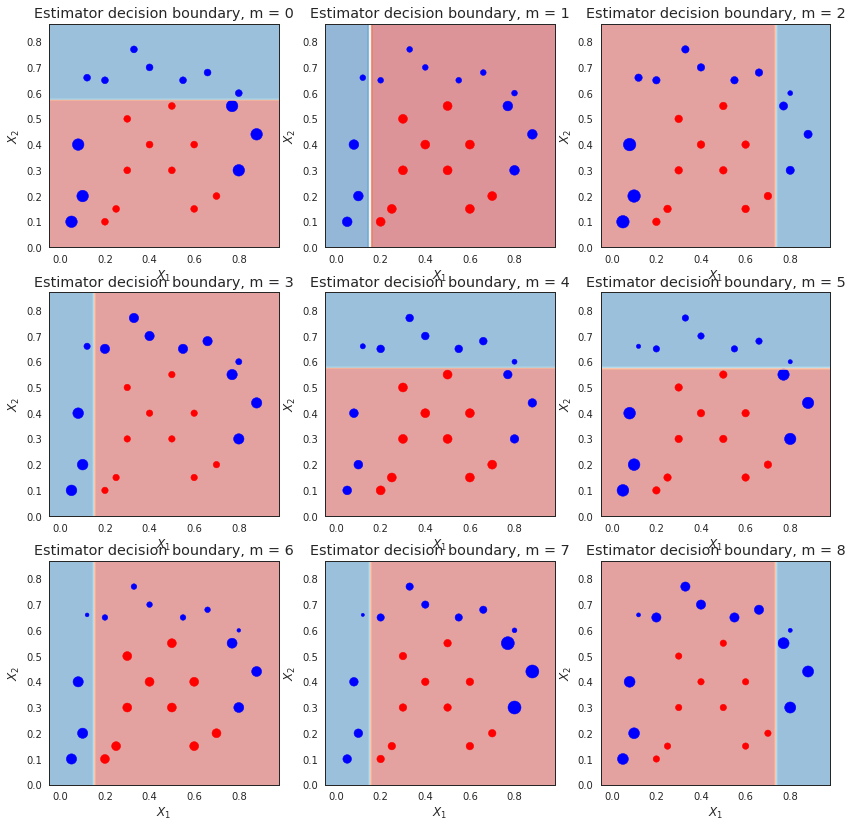

In [114]:
fig = plt.figure(figsize = (14,14))
for m in range(0,9):
    fig.add_subplot(3,3,m+1)
    s_weights = (sample_weight_list[m,:] / sample_weight_list[m,:].sum() ) * 40
    plot_decision_boundary(estimator_list[m], X, y, N = 50, scatter_weights =s_weights )
    plt.title('Estimator decision boundary, m = {}'.format(m))
print('Well Done!')

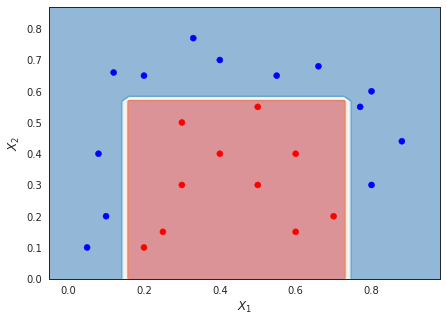

In [115]:
plot_AdaBoost_scratch_boundary(estimator_list, alpha, X, y, N = 50 )